In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split

from tqdm import tqdm
import pickle
import pandas as pd


############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import (ConvertToMultiChannelBasedOnBratsClassesd,
                                   WrapArtifactd)

from utils import show_slice_and_fourier, ReCompose, BratsValIterDataset, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [39]:
wrap_transforms = {'baseline': None, 
                  'wrap0': WrapArtifactd("image", 0.0),
                  'wrap0p125': WrapArtifactd("image", 0.125), 
                  'wrap0p25': WrapArtifactd("image", 0.25),
                  'wrap0p5': WrapArtifactd("image", 0.5),
                  'wrap0p75': WrapArtifactd("image", 0.75)}


wrap_dataloaders = BratsValIterDataset(root_dir, 1, wrap_transforms, True)

In [62]:
models_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/'

# baseline model
path = os.path.join(models_dir, 'baseline_model/best_metric_model_baseline.pth')
baseline = model_evaluation(path, 'baseline_model')

# planes12
path = os.path.join(models_dir, 'stylized_planes12/best_metric_model_planes_a55.0b55.0c30.0_int12.0.pth')
planes12 = model_evaluation(path, 'Planes12_model')

In [112]:
baseline_ds = wrap_dataloaders['baseline']
data_iter = iter(baseline_ds)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


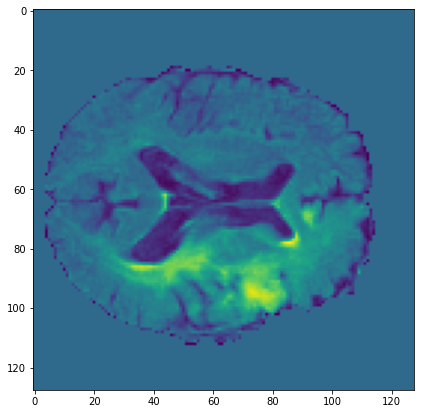

In [116]:
baseline_data = next(data_iter)
baseline_data = next(data_iter)
baseline_data = next(data_iter)
baseline_img = baseline_data['image']
plt.figure(figsize=(7,7))
plt.imshow(baseline_img[0,0,:,:,32])
plt.show()

torch.Size([2, 3, 128, 128, 64])


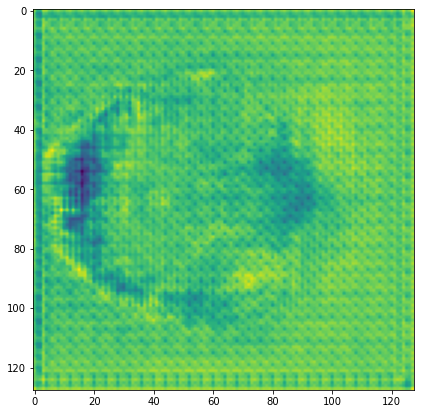

In [124]:
baseline_layer_0 = baseline.model.model[0:100]
baseline_layer_0_output = baseline_layer_0(baseline_img.cuda()).detach().cpu()
print(baseline_layer_0_output.size())
plt.figure(figsize=(7,7))
plt.imshow(baseline_layer_0_output[1,2,:,:,16])
plt.show()

torch.Size([2, 3, 128, 128, 64])


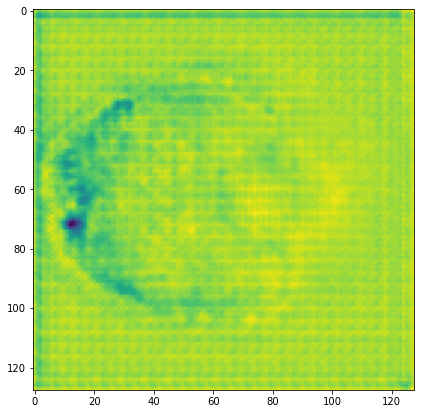

In [118]:
planes12_layer_0 = planes12.model.model[0:4]
planes12_layer_0_output = planes12_layer_0(baseline_img.cuda()).detach().cpu()
print(planes12_layer_0_output.size())
plt.figure(figsize=(7,7))
plt.imshow(planes12_layer_0_output[1,2,:,:,16])
plt.show()

In [94]:
baseline.model.model[:2]

Sequential(
  (0): ResidualUnit(
    (conv): Sequential(
      (unit0): Convolution(
        (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (adn): ADN(
          (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
      (unit1): Convolution(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
    )
    (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  )
  (1): SkipConnection(
    (submodule): Sequential(
      (0): ResidualUnit(
        (conv): Sequential(
          (unit0): Convolution(
            (conv): Conv3

In [26]:
baseline.model.model.layer[0]

AttributeError: 'Sequential' object has no attribute 'layer'